# PREDICTING NBA SALARIES USING MACHINE LEARNING

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import *

In [2]:
#NBA players stats 1950-2017
nba = pd.read_csv('NBA.csv')
#NBA annual salary cap data
salaryCap = pd.read_csv('SalaryCap.csv')

### DATA CLEANING

We will drop unknown columns and rows with NaN values, remove rows with seasons before 2000 and players with unknown salaries, rename columns for better understanding.

In [3]:
nba = nba.drop(['blanl', 'blank2'], axis=1)
nba = nba.drop(nba.tail(2).index)
nba = nba[(nba[' Player Salary in $ '].notna()) & (nba['Season Start'] >= 2000)]
nba.rename(columns={"Pos": "Position","Tm": "Team","G":"Games Played","GS":"Games Started"," Player Salary in $ ":"Salary","Season Start":"Season", "MP":"Minutes Played"}, inplace=True)

We will also remove the dollar sign in the salary column and convert percentages to decimals.

In [4]:
nba['Salary'] = nba['Salary'].str.replace(',','').str.replace('$','')
nba['Salary'] = nba['Salary'].astype(float)
for c in nba.columns:
    if c[-1] == '%' or c == 'FTr':
        if nba[c].dtype == object:
            nba[c] = nba[c].str.replace('%','')
            nba[c] = nba[c].astype(float)
            nba[c] = nba[c] / 100.0   

Since players who have played less than a certain amount of games may distort the data later on when doing analysis, it makes sense to only keep players who have played at least 10 games.

In [5]:
nba = nba[nba['Games Played'] >= 10]

Some positions are the same, but named differently.

In [6]:
nba['Position'].replace("SG-PG", "PG-SG", True)
nba['Position'].replace("SF-SG", "SG-SF", True)
nba['Position'].replace("PF-SF", "SF-PF", True)
nba['Position'].replace("C-PF", "PF-C", True)
nba['Position'].replace(["PG-SF", "SG-PF"], "SF", True)

### DATA ANALYSIS

This is the distribution of NBA salaries.

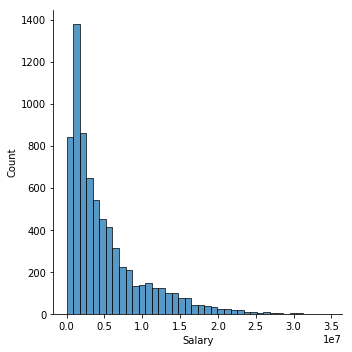

In [7]:
sns.displot(nba['Salary'], bins=40);

The graph below shows how the mean salary changes for each age.

Text(0, 0.5, 'Mean Salary')

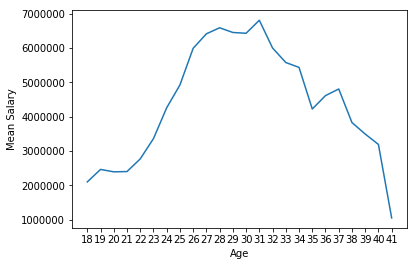

In [8]:
salaryByAge = nba.groupby('Age').mean()[['Salary']].reset_index()
plt.plot(salaryByAge['Age'], salaryByAge['Salary'])
plt.xticks(salaryByAge['Age'])
plt.xlabel('Age')
plt.ylabel('Mean Salary')

This plot shows the average salaries for each position.

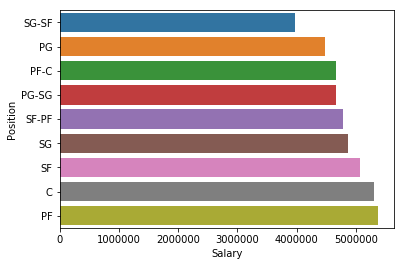

In [9]:
salaryByPosition = nba.groupby('Position').mean().sort_values('Salary')[['Salary']]
sns.barplot(x='Salary', y=salaryByPosition.index, data=salaryByPosition, ci=False);

This plot shows the average salary of a player by team.

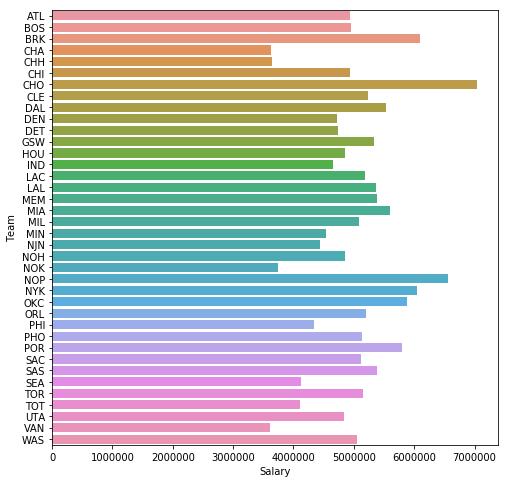

In [10]:
salaryByTeam = nba.groupby('Team').mean()[['Salary']].reset_index()
plt.figure(figsize=(8,8))
sns.barplot(x='Salary', y='Team', data=nba, ci=False, order=salaryByTeam['Team']);

### FEATURE ENGINEERING

It would be better to convert totals to per game stats.

In [11]:
totals = ['Minutes Played', 'FG', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
for c in totals:
    nba[c + '/G'] = nba[c] / nba['Games Played']
nba.drop(totals, axis=1, inplace=True)

Since NBA Salary Cap changes every year, the 'Salary' column needs to be inflation adjusted.

In [12]:
nba = nba.merge(salaryCap)
nba['Inflated Salary'] = (salaryCap['SalaryCap'].iloc[-1] / nba['SalaryCap']) * nba['Salary']
nba.drop('SalaryCap', axis=1, inplace=True)

For machine learning, we need to know which features are most correlated with NBA salary.

In [13]:
salaryCorrelation = nba.corr()['Inflated Salary'].sort_values().drop(['Salary', 'Inflated Salary'])
mostCorrelated = salaryCorrelation[salaryCorrelation > .5]
mostCorrelated

BPM                 0.503586
DWS                 0.510674
TRB/G               0.528519
Games Started       0.536658
OWS                 0.536727
PER                 0.537444
VORP                0.565624
DRB/G               0.575513
TOV/G               0.579447
WS                  0.585007
FT/G                0.612241
FTA/G               0.617325
Minutes Played/G    0.625509
2PA/G               0.641944
FGA/G               0.642437
2P/G                0.646128
PTS/G               0.660813
FG/G                0.661759
Name: Inflated Salary, dtype: float64

However, not all of these features need to be used since many of them have high colinearity.

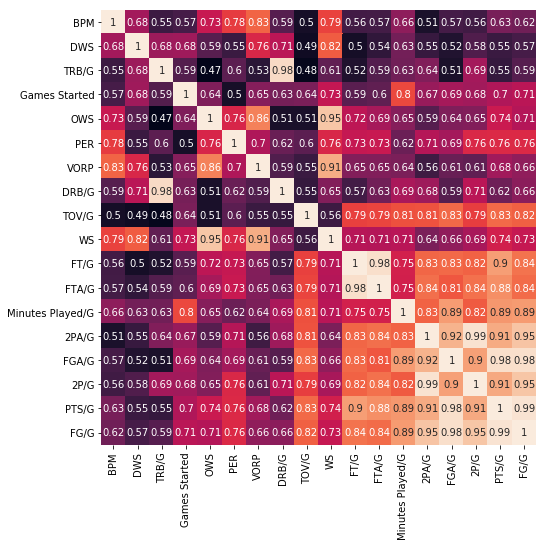

In [14]:
corrMatrix = nba.corr()[mostCorrelated.index].loc[mostCorrelated.index]
plt.figure(figsize=(8,8))
sns.heatmap(corrMatrix, cbar=False, annot=True, square=True);

These will be the features used for machine learning:

In [15]:
features = ['PTS/G', 'Minutes Played/G', 'FTA/G', 'WS', 'TOV/G', 'DRB/G', 'VORP', 'PER', 'Games Started', 'DWS', 'BPM']
features

['PTS/G',
 'Minutes Played/G',
 'FTA/G',
 'WS',
 'TOV/G',
 'DRB/G',
 'VORP',
 'PER',
 'Games Started',
 'DWS',
 'BPM']

### MACHINE LEARNING

To reduce skewed data, we will standardize the data.

In [16]:
scaler = preprocessing.StandardScaler().fit(nba[features])
x = scaler.transform(nba[features])

The data is split into random train and test subsets for modeling.

In [17]:
y = nba['Inflated Salary'] 
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y)

To determine the best model, we will test different machine learning models.

**Linear Regression Model**

In [18]:
lr = linear_model.LinearRegression().fit(x_train, y_train)
lrTestPredictions = lr.predict(x_test)
lrRMSE = metrics.mean_squared_error(y_test, lrTestPredictions, squared=False)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_base.py:569: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


**Decision Tree Model**

In [19]:
dt = tree.DecisionTreeRegressor().fit(x_train, y_train)
dtTestPredictions = dt.predict(x_test)
dtRMSE = metrics.mean_squared_error(y_test, dtTestPredictions, squared=False)

**Random Forest Model**

In [20]:
rf = ensemble.RandomForestRegressor().fit(x_train, y_train)
rfTestPredictions = rf.predict(x_test)
rfRMSE = metrics.mean_squared_error(y_test, rfTestPredictions, squared=False)

It looks like the random forest model has the lowest RMSE.

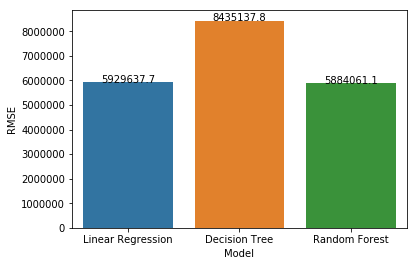

In [21]:
rmse = pd.DataFrame({"Model": ["Linear Regression", "Decision Tree", "Random Forest"], "RMSE": [lrRMSE, dtRMSE, rfRMSE]})
rmseBars = sns.barplot(x="Model", y="RMSE", data=rmse);
for bar in rmseBars.patches:
    rmseBars.annotate(format(bar.get_height(), '.1f'), (bar.get_x() + bar.get_width() / 2, bar.get_height()), ha='center')

Since the random forest model has the lowest RMSE, we will use that to make our salary predictions.

In [22]:
salaryPredictions = rf.predict(x)
nba['Predicted Salary'] = salaryPredictions

### DATA VISUALIZATION

Now that the predictions have been made, we can visualize how they compare to actual salaries.

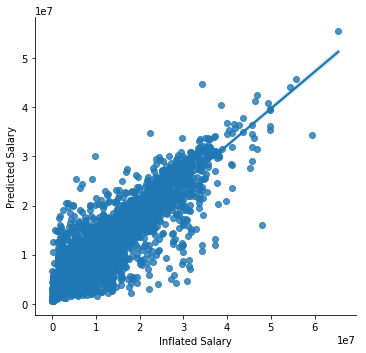

In [23]:
sns.lmplot(x='Inflated Salary', y='Predicted Salary', data=nba);

This graph demonstrates how average salaries will change based on age.

Text(0, 0.5, 'Mean Predicted Salary')

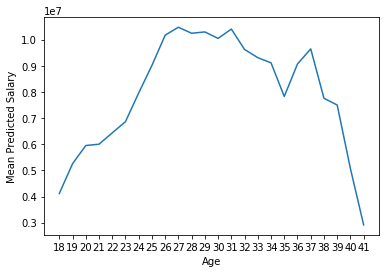

In [24]:
predictedSalaryByAge = nba.groupby('Age').mean()[['Predicted Salary']].reset_index()
plt.plot(predictedSalaryByAge['Age'], predictedSalaryByAge['Predicted Salary'])
plt.xticks(predictedSalaryByAge['Age'])
plt.xlabel('Age')
plt.ylabel('Mean Predicted Salary')

With predicted salaries, players can be classified as either overvalued or undervalued.

In [25]:
nba['Salary Difference'] = nba['Inflated Salary'] - nba['Predicted Salary']
nba["Overvalued"] = nba['Salary Difference'] > 0

This is a distribution of overvalued and undervalued players based on age.

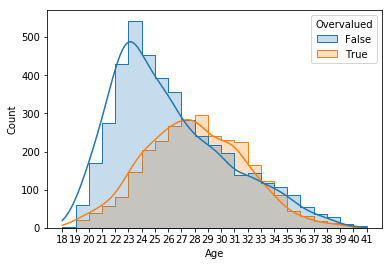

In [26]:
plt.xticks(nba['Age'].unique())
sns.histplot(data=nba, x='Age', kde=True, bins=int(max(nba['Age'])-min(nba['Age'])), hue='Overvalued', element='step');

Which positions are overvalued (Average Salary Difference > 0) and undervalued?

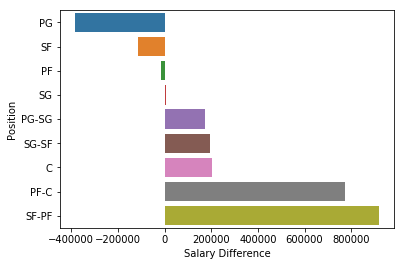

In [27]:
salaryDifferenceByPosition = nba.groupby('Position').mean().sort_values('Salary Difference')[['Salary Difference']]
sns.barplot(x='Salary Difference', y=salaryDifferenceByPosition.index, data=salaryDifferenceByPosition);

How much does each team overvalue (Average Salary Difference > 0) or undervalue their players?

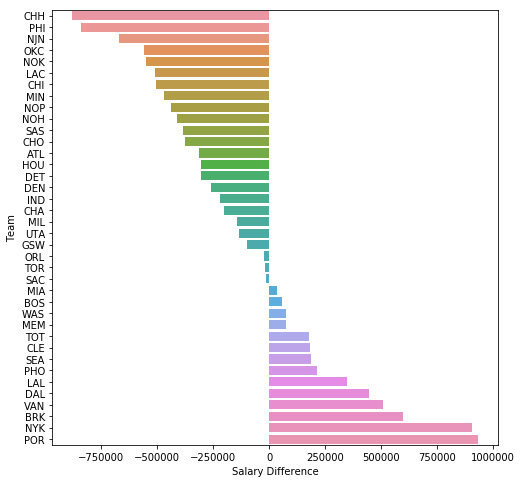

In [28]:
salaryDifferenceByTeam = nba.groupby('Team').mean().sort_values('Salary Difference')[['Salary Difference']]
plt.figure(figsize=(8,8))
sns.barplot(x='Salary Difference', y=salaryDifferenceByTeam.index, data=salaryDifferenceByTeam);

This visualization shows how many overvalued players have been on each team since 2000.

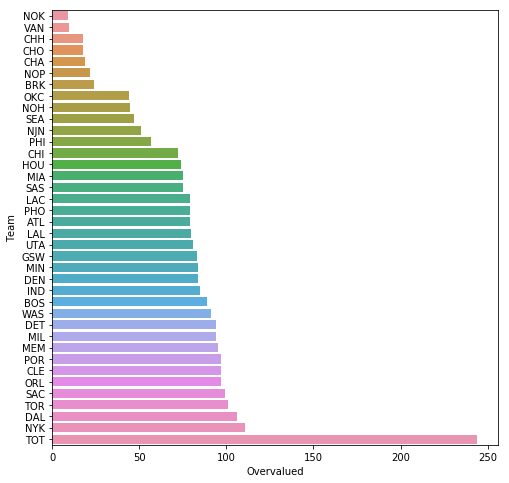

In [29]:
teamOvervaluedCount = nba.groupby('Team').sum().sort_values('Overvalued')[['Overvalued']]
plt.figure(figsize=(8,8))
sns.barplot(x='Overvalued', y=teamOvervaluedCount.index, data=teamOvervaluedCount);

This visualization shows how many undervalued players have been on each team since 2000.

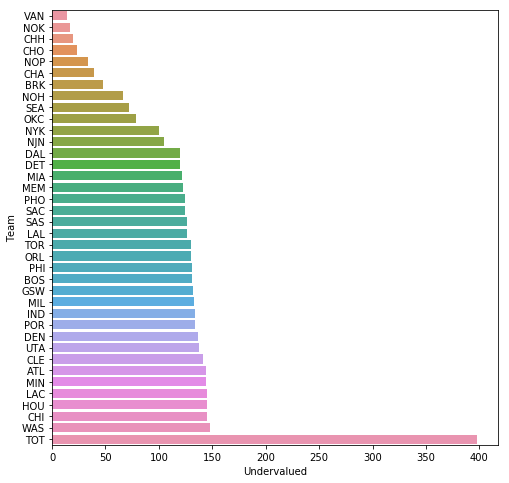

In [30]:
undervalued = nba[nba['Overvalued'] == False]
undervalued = undervalued.rename(columns={"Overvalued": "Undervalued"})
teamUndervaluedCount = undervalued.groupby('Team').count().sort_values('Undervalued')[['Undervalued']]
plt.figure(figsize=(8,8))
sns.barplot(x='Undervalued', y=teamUndervaluedCount.index, data=teamUndervaluedCount);

10 most undervalued players for each season since 2000:

In [31]:
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.2f}'.format
mostUndervalued = nba.sort_values(['Season', 'Salary Difference']).groupby('Season').head(10)[['Season', 'Player Name', 'Inflated Salary', 'Predicted Salary', 'Salary Difference']].reset_index(drop=True)
mostUndervalued

,Season,Player Name,Inflated Salary,Predicted Salary,Salary Difference
0,2000.00,Vince Carter,6715829.35,24413986.70,-17698157.35
1,2000.00,Elton Brand,10048823.82,21496808.56,-11447984.74
2,2000.00,Isaiah Rider,2037919.06,12448950.02,-10411030.97
3,2000.00,Maurice Taylor,6230051.47,16452123.90,-10222072.42
4,2000.00,Jerry Stackhouse,14702921.47,23178758.74,-8475837.27
5,2000.00,Troy Hudson,1449525.31,9387042.23,-7937516.92
6,2000.00,Anthony Mason,15367460.29,23092889.46,-7725429.17
7,2000.00,Adrian Griffin,1380302.51,8823974.47,-7443671.95
8,2000.00,Paul Pierce,4454736.00,10714750.47,-6260014.47
9,2000.00,Larry Hughes,5101664.55,10910198.36,-5808533.81


10 most overvalued players for each season since 2000:

In [32]:
mostOvervalued = nba.sort_values(['Season', 'Salary Difference'],ascending=[True, False]).groupby('Season').head(10)[['Season', 'Player Name', 'Inflated Salary', 'Predicted Salary', 'Salary Difference']].reset_index(drop=True)
mostOvervalued

,Season,Player Name,Inflated Salary,Predicted Salary,Salary Difference
0,2000.00,Juwan Howard,46725386.03,31431792.12,15293593.91
1,2000.00,Mitch Richmond*,27689117.65,14462444.68,13226672.96
2,2000.00,Hakeem Olajuwon*,46240826.47,33742949.08,12497877.39
3,2000.00,Tim Thomas,23563439.12,12527361.56,11036077.55
4,2000.00,Shawn Kemp,32451645.88,21952360.66,10499285.22
5,2000.00,Kevin Garnett,54298359.71,44179569.55,10118790.16
6,2000.00,Damon Stoudamire,31150257.35,21985732.94,9164524.41
7,2000.00,Duane Causwell,11075647.06,2511417.23,8564229.83
8,2000.00,Isaac Austin,15229014.71,7187118.13,8041896.57
9,2000.00,Scottie Pippen*,38072536.76,30048531.66,8024005.10
